# Tutorial 06

## template fitting pipeline pre-process

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

vmap30 = hp.read_map('./data/plkvar_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap95 = hp.read_map('./data/alivar_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap150 = hp.read_map('./data/alivar_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
vmap353 = hp.read_map('./data/plkvar_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)

nmap30 = np.random.normal(0.,1.,size=vmap30.shape)*np.sqrt(vmap30)
nmap95 = np.random.normal(0.,1.,size=vmap95.shape)*np.sqrt(vmap95)
nmap150 = np.random.normal(0.,1.,size=vmap150.shape)*np.sqrt(vmap150)
nmap353 = np.random.normal(0.,1.,size=vmap353.shape)*np.sqrt(vmap353)

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
map30 = hp.smoothing(mapcmb+map30f,fwhm=fwhm[0],verbose=0)+nmap30
map95 = hp.smoothing(mapcmb+map95f,fwhm=fwhm[1],verbose=0)+nmap95
map150 = hp.smoothing(mapcmb+map150f,fwhm=fwhm[2],verbose=0)+nmap150
map353 = hp.smoothing(mapcmb+map353f,fwhm=fwhm[3],verbose=0)+nmap353

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

#### simple likelihood pre-process

- T maps

CPU times: user 16min 50s, sys: 470 ms, total: 16min 50s
Wall time: 2min 7s


<AxesSubplot:>

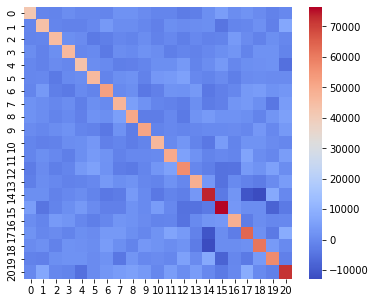

In [2]:
%%time

RESAMP = 30
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

fullmap = dict()
fullmap[95] = map95[0].reshape(1,-1)
fullmap[150] = map150[0].reshape(1,-1)

fullvar = dict()
fullvar[95] = vmap95[0].reshape(1,-1)
fullvar[150] = vmap150[0].reshape(1,-1)

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

tmpmap = dict()
tmpmap[30] = map30f[0].reshape(1,-1)
tmpmap[353] = map353f[0].reshape(1,-1)

tmpbeam = dict()
tmpbeam[30] = fwhm[0]
tmpbeam[353] = fwhm[3]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam,
                      templates=tmpmap,template_fwhms=tmpbeam)
rslt_t = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,nsamp=RESAMP)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(rslt_t[3],cmap='coolwarm',annot=False,ax=ax)

- QU maps

CPU times: user 31min 52s, sys: 3.69 s, total: 31min 56s
Wall time: 4min 2s


<AxesSubplot:>

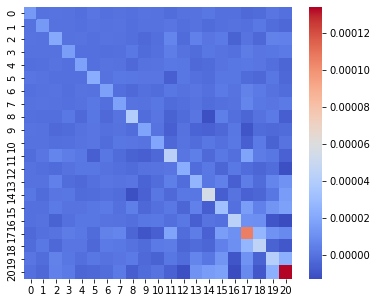

In [3]:
%%time

RESAMP = 30
APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

fullmap = dict()
fullmap[95] = map95[1:]
fullmap[150] = map150[1:]

fullvar = dict()
fullvar[95] = vmap95[1:]
fullvar[150] = vmap150[1:]

fullbeam = dict()
fullbeam[95] = fwhm[1]
fullbeam[150] = fwhm[2]

tmpmap = dict()
tmpmap[30] = map30f[1:]
tmpmap[353] = map353f[1:]

tmpbeam = dict()
tmpbeam[30] = fwhm[0]
tmpbeam[353] = fwhm[3]

pipeline = af.tpfpipe(fullmap,mask=mask.reshape(1,-1),variances=fullvar,fwhms=fullbeam,
                      templates=tmpmap,template_fwhms=tmpbeam)
rslt_eb = pipeline.preprocess(aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX,nsamp=RESAMP)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(rslt_eb[3],cmap='coolwarm',annot=False,ax=ax)

#### window function matrix (top-hat according to NaMaster)

<AxesSubplot:>

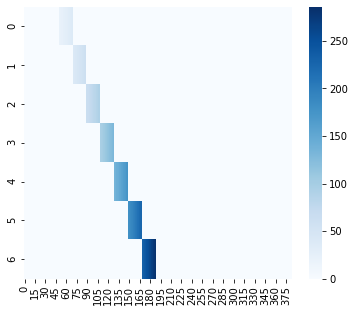

In [4]:
from afra.tools.ps_estimator import pstimator
from afra.tools.aux import bp_window

APOSCALE = 6.
PSBIN = 20
LMIN = 50
LMAX = 200

est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=PSBIN,lmin=LMIN,lmax=LMAX)
window = bp_window(est)

fig,ax = plt.subplots(figsize=(6,5))
sns.heatmap(window,cmap='Blues',annot=False,ax=ax)

end